
# __L'urbanisation est-elle corrélée à la croissance économique ?__
_Groupe MEF 2 - __Hamelin Simon, Balde-Cisse Ibrahima, Marmelat Paul, Pupier Charly__._

## **Objectif :**  
Ce notebook explore la relation entre l'urbanisation et la croissance économique (PIB par habitant).  
Nous allons d'abord analyser **seulement l'urbanisation et le PIB**, puis nous verrons comment **ajouter l'éducation** impacte cette relation.

### **🔹 Étapes du Notebook :**  
1. **Importation des bibliotèques** 📚
2. **Chargement et exploration des données** 📂  
3. **Nettoyage des données** (Suppression des régions, outliers, etc.) 🧹  
4. **Analyse de corrélation Urbanisation - PIB** 📈 
5. **Ajout de l'éducation et nouvelle régression multiple** 🎓  
6. **Comparaison des modèles et impact de l’éducation** 📊  


## 📚 Importation des bibliotèques

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [11]:
# Création des dossiers img et OLS si ils n'existent pas
import os
if not os.path.exists("../outputs/img"):
    os.mkdir("../outputs/img")
if not os.path.exists("../outputs/OLS"):
    os.mkdir("../outputs/OLS")

## 📂 Chargement des fichiers de données

In [12]:
# Chargement des fichiers
output_path = "../outputs/"
urbanisation_path = "../inputs/urbanisation.csv"
gdp_path = "../inputs/gdp_per_capita.csv"
education_path = "../inputs/education.csv"
valid_countries_path = "../inputs/valid_countries.csv"

# Lire les fichiers CSV
urbanisation_df = pd.read_csv(urbanisation_path, skiprows=4)
gdp_df = pd.read_csv(gdp_path, skiprows=4)
education_df = pd.read_csv(education_path, skiprows=4)
valid_countries_df = pd.read_csv(valid_countries_path)

# Affichage des premières lignes
urbanisation_df.head(), gdp_df.head(), education_df.head()

(  Country Name Country Code                   Indicator Name  \
 0        Aruba          ABW  Population urbaine (% du total)   
 1          NaN          AFE  Population urbaine (% du total)   
 2  Afghanistan          AFG  Population urbaine (% du total)   
 3          NaN          AFW  Population urbaine (% du total)   
 4       Angola          AGO  Population urbaine (% du total)   
 
       Indicator Code       1960       1961       1962       1963       1964  \
 0  SP.URB.TOTL.IN.ZS  50.776000  50.761000  50.746000  50.730000  50.715000   
 1  SP.URB.TOTL.IN.ZS  14.576676  14.825175  15.083802  15.363045  15.655383   
 2  SP.URB.TOTL.IN.ZS   8.401000   8.684000   8.976000   9.276000   9.586000   
 3  SP.URB.TOTL.IN.ZS  14.710006  15.094445  15.487932  15.900682  16.331319   
 4  SP.URB.TOTL.IN.ZS  10.435000  10.798000  11.204000  11.624000  12.058000   
 
         1965  ...       2015       2016       2017       2018       2019  \
 0  50.700000  ...  43.108000  43.192000  43.2930

## 🧹 Nettoyage des données

In [13]:
# Suppression des colonnes inutiles
urbanisation_df = urbanisation_df.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], errors='ignore')
gdp_df = gdp_df.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], errors='ignore')

# Transformation en format long
urbanisation_long = urbanisation_df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urbanization")
gdp_long = gdp_df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP_per_capita")

# Conversion de l'année en numérique
urbanisation_long["Year"] = pd.to_numeric(urbanisation_long["Year"], errors='coerce')
gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors='coerce')

# Fusion des datasets
merged_df = urbanisation_long.merge(gdp_long, on=["Country Name", "Country Code", "Year"], how="inner")

# Filtrer pour garder uniquement les pays
merged_df = merged_df[merged_df["Country Code"].isin(valid_countries_df["Country Code"])]

# Suppression des micro-états
micro_states = ["Andorra", "Liechtenstein", "Malta", "Monaco", "San Marino", "Nauru", "Tuvalu", "Palau", "Marshall Islands", "Kiribati", "Micronesia, Fed. Sts.", "Seychelles", "St. Kitts and Nevis", "St. Lucia", "St. Vincent and the Grenadines", "Antigua and Barbuda", "Barbados", "Grenada", "Maldives", "Sao Tome and Principe", "Comoros", "Cabo Verde", "Bahrain", "Malta", "Maldives"]
merged_df = merged_df[~merged_df["Country Name"].isin(micro_states)]

# Enlever les valeurs manquantes
merged_df = merged_df.dropna()

# Vérification des données
merged_df.head(10)

,Country Name,Country Code,Year,Urbanization,GDP_per_capita
13,Australie,AUS,1960,81.529,1810.706430
14,Autriche,AUT,1960,64.720,939.914815
16,Burundi,BDI,1960,2.077,70.905100
17,Belgique,BEL,1960,92.460,1290.286072
18,Bénin,BEN,1960,9.275,89.856925
19,Burkina Faso,BFA,1960,4.700,69.150246
20,Bangladesh,BGD,1960,5.135,82.481277
23,Bahamas,BHS,1960,59.712,1459.253539
26,Belize,BLZ,1960,54.028,307.414508
27,Bermudes,BMU,1960,100.000,1715.314632


## 🔍 Suppression des valeurs aberrantes et nettoyage final

In [14]:
# Détection et suppression des outliers (1% des valeurs extrêmes)
Q1_urban = merged_df["Urbanization"].quantile(0.01)
Q3_urban = merged_df["Urbanization"].quantile(0.99)
Q1_gdp = merged_df["GDP_per_capita"].quantile(0.01)
Q3_gdp = merged_df["GDP_per_capita"].quantile(0.99)

merged_df = merged_df[(merged_df["Urbanization"] >= Q1_urban) & (merged_df["Urbanization"] <= Q3_urban)]
merged_df = merged_df[(merged_df["GDP_per_capita"] >= Q1_gdp) & (merged_df["GDP_per_capita"] <= Q3_gdp)]

# Suppression des années avant 1980 (meilleure qualité des données)
merged_df = merged_df[merged_df["Year"] >= 1980]

# Affichage des données après nettoyage
merged_df.head(10)

,Country Name,Country Code,Year,Urbanization,GDP_per_capita
5324,Angola,AGO,1980,24.298,729.111965
5325,Albanie,ALB,1980,33.762,590.607738
5326,Andorre,AND,1980,92.064,12474.925292
5328,Émirats arabes unis,ARE,1980,80.710,42925.233878
5329,Argentine,ARG,1980,82.887,2747.502275
5332,Antigua-et-Barbuda,ATG,1980,34.618,2052.931049
5333,Australie,AUS,1980,85.552,10208.803684
5334,Autriche,AUT,1980,65.391,10826.971827
5337,Belgique,BEL,1980,95.381,12864.002566
5338,Bénin,BEN,1980,27.339,358.003054


## 📈 Première analyse des données

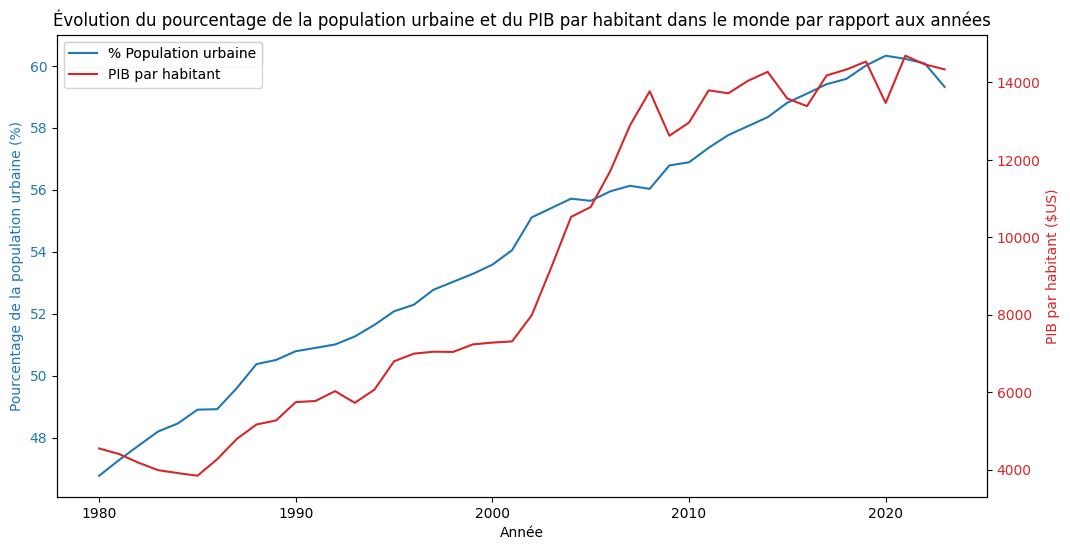

In [15]:
# Tracer le pourcentage de la population urbaine et le PIB par habitant par rapport aux années pour le monde
fig, ax1 = plt.subplots(figsize=(12, 6))

# Première courbe : Population urbaine
color = 'tab:blue'
ax1.set_xlabel('Année')
ax1.set_ylabel('Pourcentage de la population urbaine (%)', color=color)
sns.lineplot(data=merged_df, x="Year", y="Urbanization", ax=ax1, color=color, label="% Population urbaine", errorbar=None)
ax1.tick_params(axis='y', labelcolor=color)

# Deuxième courbe : PIB par habitant
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PIB par habitant ($US)', color=color)
sns.lineplot(data=merged_df, x="Year", y="GDP_per_capita", ax=ax2, color=color, label="PIB par habitant", errorbar=None)
ax2.tick_params(axis='y', labelcolor=color)

# Légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("Évolution du pourcentage de la population urbaine et du PIB par habitant dans le monde par rapport aux années")
plt.show()

fig.savefig(output_path+"img/1_Population_Urbanisation_PIB.png")

## 📈 Régression Urbanisation - PIB -> Tous les pays

In [16]:
# Transformation log-log
merged_df["log_Urbanization"] = np.log(merged_df["Urbanization"])
merged_df["log_GDP_per_capita"] = np.log(merged_df["GDP_per_capita"])

# Modèle OLS simple (Urbanisation -> PIB)
X_simple = sm.add_constant(merged_df["log_Urbanization"])
y = merged_df["log_GDP_per_capita"]
model_simple = sm.OLS(y, X_simple).fit()

# Affichage des résultats
print(model_simple.summary())

# Sauvegarder le résumé du modèle OLS simple dans un fichier texte
with open(output_path + "OLS/1_MCO_Urbanisation_PIB.txt", "w") as f:
    f.write("MCO simple : Urbanisation -> PIB\n")
    f.write(model_simple.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:     log_GDP_per_capita   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     8673.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:05:11   Log-Likelihood:                -12071.
No. Observations:                7985   AIC:                         2.415e+04
Df Residuals:                    7983   BIC:                         2.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1715      0.090  

## 📊 Visualisation : Corrélation Urbanisation - PIB

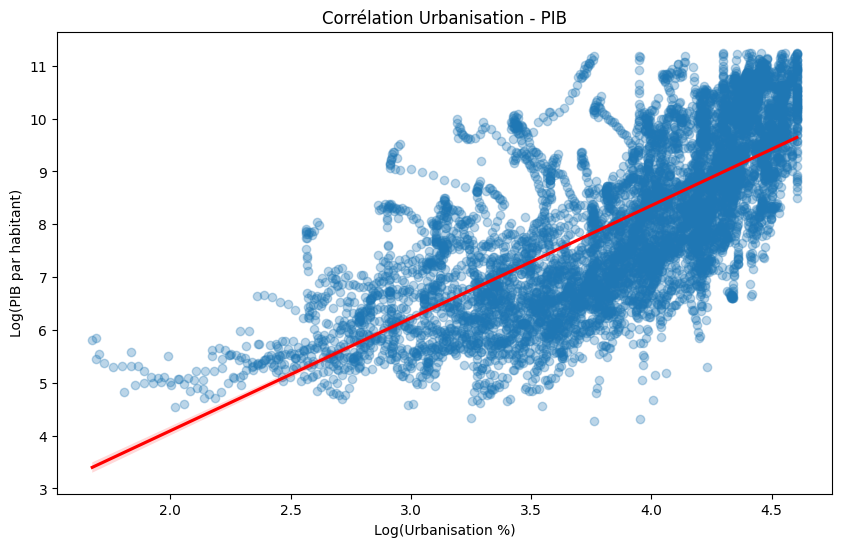

In [17]:
# Tracer la régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df["log_Urbanization"], y=merged_df["log_GDP_per_capita"], scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel("Log(Urbanisation %)")
plt.ylabel("Log(PIB par habitant)")
plt.title("Corrélation Urbanisation - PIB")

# Sauvegarde et affichage du graphique
plt.savefig(output_path + "img/2_Correlation_Urbanisation_PIB.png")
plt.show()


Modèle pour France:
                            OLS Regression Results                            
Dep. Variable:     log_GDP_per_capita   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     131.3
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.64e-14
Time:                        00:05:12   Log-Likelihood:                0.87861
No. Observations:                  44   AIC:                             2.243
Df Residuals:                      42   BIC:                             5.811
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              

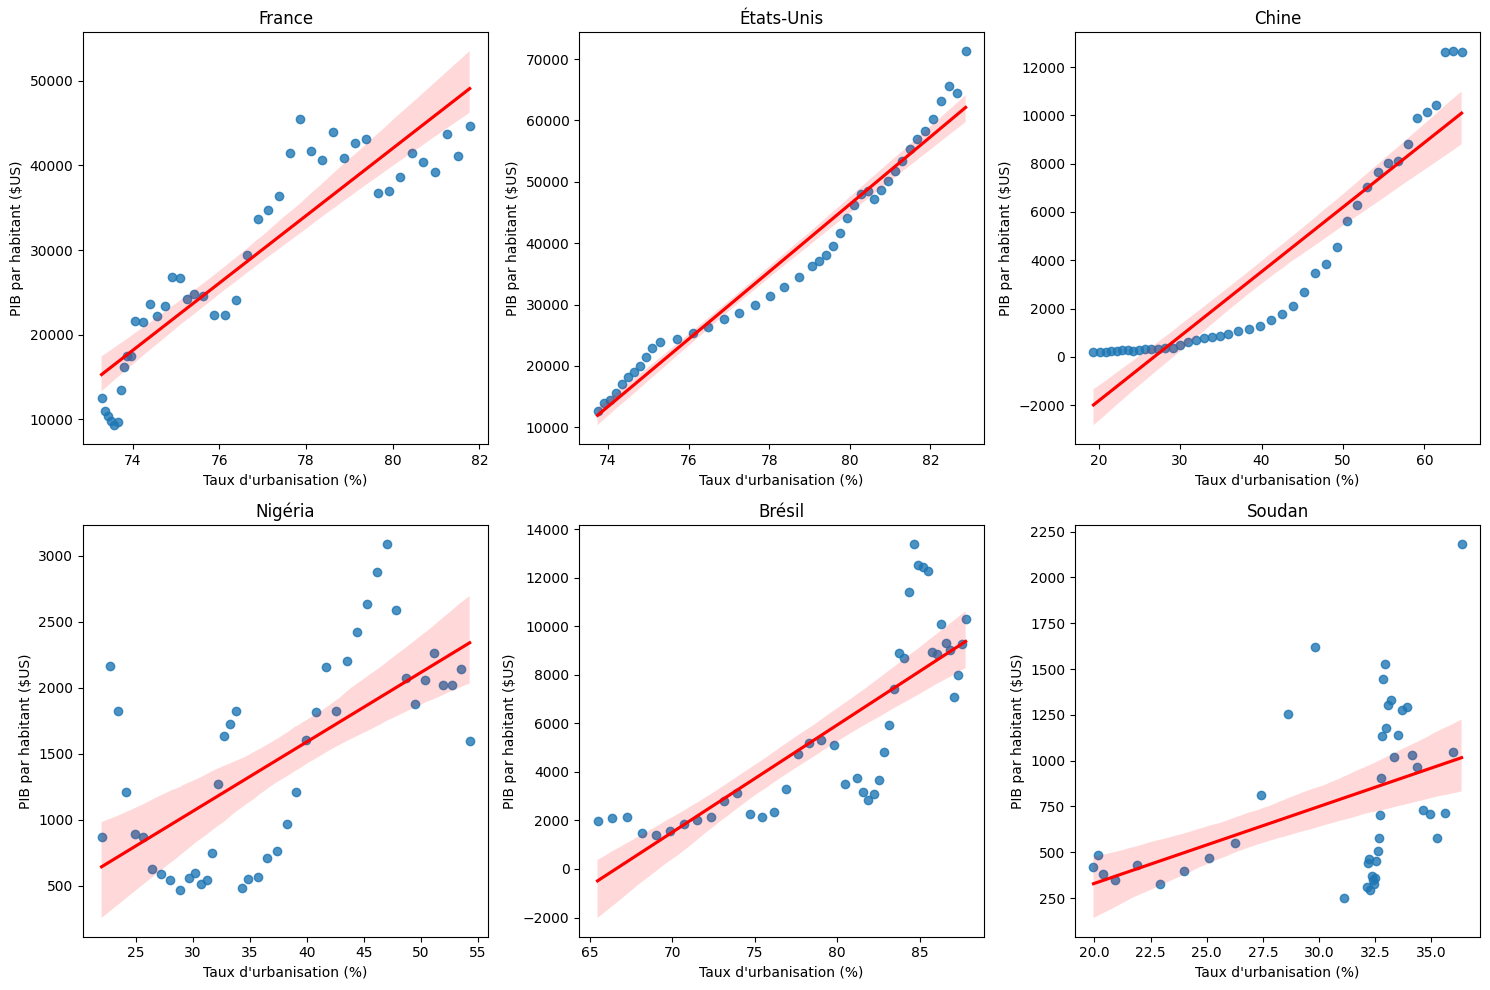

In [18]:
# Sélection des pays
selected_countries = ["France", "États-Unis", "Chine", "Nigéria", "Brésil", "Soudan"]
country_models = {}

# Création des graphiques pour chaque pays
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, country in enumerate(selected_countries):
    country_data = merged_df[merged_df["Country Name"] == country]

    # MCO
    X_country = sm.add_constant(country_data["log_Urbanization"])
    y_country = country_data["log_GDP_per_capita"]
    model_country = sm.OLS(y_country, X_country).fit()

    country_models[country] = model_country.summary()

    # Affichage du résumé du modèle pour chaque pays
    print(f"\nModèle pour {country}:")
    print(model_country.summary())

    # Tracé du nuage de points avec régression linéaire
    sns.regplot(ax=axes[i], x=country_data["Urbanization"], y=country_data["GDP_per_capita"], line_kws={'color': 'red'})
    
    # Légende
    axes[i].set_title(f"{country}")
    axes[i].set_xlabel("Taux d'urbanisation (%)")
    axes[i].set_ylabel("PIB par habitant ($US)")

# Sauvegarde et affichage
country_models
with open(output_path + "OLS/2_MCO_Urbanisation_PIB_Pays.txt", "w") as f:
    for country, model in country_models.items():
        f.write(f"MCO simple : Urbanisation -> PIB pour {country}:\n")
        f.write(model.as_text())
        f.write("\n\n")
        
fig.savefig(output_path+"img/3_Correlation_Urbanisation_PIB_Pays.png")
plt.tight_layout()
plt.show()

## 🎓 Ajout de l'Éducation et nouvelle régression multiple

In [19]:
### Même chose pour l'éducation

# Suppression des colonnes inutiles
education_df = education_df.drop(columns=["Indicator Name", "Indicator Code", "Unnamed: 68"], errors='ignore')

# Transformation en format "long" (melt) pour avoir une colonne "Year"
education_long = education_df.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Education_Access")
education_long["Year"] = pd.to_numeric(education_long["Year"], errors='coerce')

# Fusionner avec les données existantes sur une base commune (Country, Year)
merged_final = pd.merge(merged_df, education_long, on=["Country Name", "Country Code", "Year"], how="inner")

# Suppression des lignes avec valeurs manquantes pour Education_Access
merged_final = merged_final.dropna(subset=["Education_Access"])
merged_final["log_Education"] = np.log(merged_final["Education_Access"])

merged_final.head(10)

,Country Name,Country Code,Year,Urbanization,GDP_per_capita,log_Urbanization,log_GDP_per_capita,Education_Access,log_Education
9,Bénin,BEN,1980,27.339,358.003054,3.308314,5.880542,81.15874,4.396407
10,Burkina Faso,BFA,1980,8.805,277.597531,2.175320,5.626172,33.76022,3.519283
12,Bulgarie,BGR,1980,62.100,2238.802958,4.128746,7.713697,99.04887,4.595613
18,Brésil,BRA,1980,65.468,1958.571592,4.181561,7.579971,89.00044,4.488641
20,Brunéi Darussalam,BRN,1980,64.949,58005.342476,4.173602,10.968290,95.75422,4.561785
23,République centrafricaine,CAF,1980,33.874,325.254770,3.522648,5.784609,53.10879,3.972342
28,Côte d'Ivoire,CIV,1980,36.829,1237.802168,3.606286,7.121093,55.85441,4.022748
29,Cameroun,CMR,1980,31.921,784.116227,3.463264,6.664557,35.62180,3.572958
31,"Congo, République du",COG,1980,47.857,932.646715,3.868217,6.838026,99.34511,4.598600
34,Costa Rica,CRI,1980,43.099,2020.990675,3.763500,7.611343,56.67581,4.037347


In [20]:
# Régression multiple avec Urbanisation + Éducation
X_multi = merged_final[["log_Urbanization", "log_Education"]]
X_multi = sm.add_constant(X_multi)
y_multi = merged_final["log_GDP_per_capita"]

# Modèle de régression multiple
model_multi = sm.OLS(y_multi, X_multi).fit()

# Affichage du résumé du modèle
print(model_multi.summary())

# Sauvegarder le résumé du modèle dans outputs
with open(output_path + "OLS/3_MCO_Urbanisation_Education_PIB.txt", "w") as f:
    f.write("MCO multiple : Urbanisation + Education -> PIB\n")
    f.write(model_multi.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:     log_GDP_per_capita   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     1769.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:05:14   Log-Likelihood:                -3631.9
No. Observations:                2643   AIC:                             7270.
Df Residuals:                    2640   BIC:                             7287.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.9306      0.357  

## 📊 Visualisation : Impact de l'Éducation

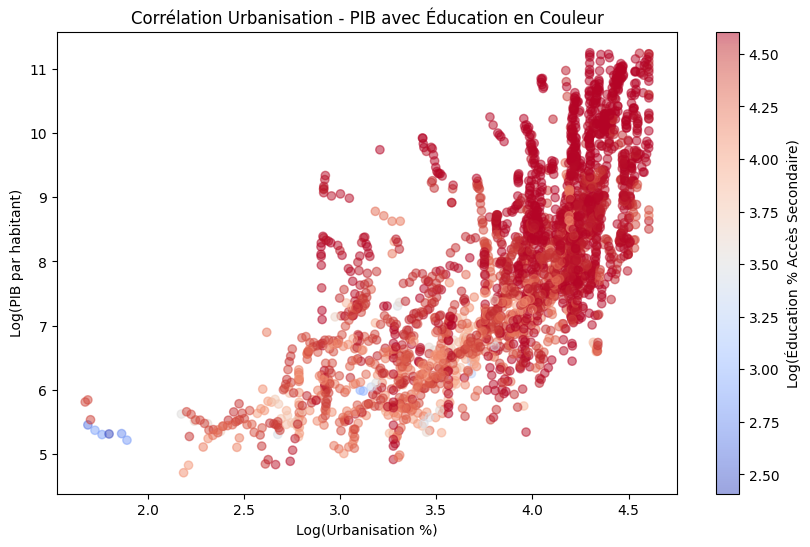

In [21]:
# Tracé de la régression linéaire multiple
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    merged_final["log_Urbanization"],
    merged_final["log_GDP_per_capita"],
    c=merged_final["log_Education"],
    cmap="coolwarm",
    alpha=0.5
)
plt.colorbar(scatter, label="Log(Éducation % Accès Secondaire)")

plt.xlabel("Log(Urbanisation %)")
plt.ylabel("Log(PIB par habitant)")
plt.title("Corrélation Urbanisation - PIB avec Éducation en Couleur")

# Sauvegarde et affichage du graphique
plt.savefig(output_path + "img/4_Correlation_Urbanisation_Education_PIB.png")
plt.show()


## 🆚 Comparaison des modèles

In [22]:
# Comparaison des R²
print("R² Modèle Urbanisation-PIB :", model_simple.rsquared.round(3))
print("R² Modèle Urbanisation + Éducation - PIB :", model_multi.rsquared.round(3))

R² Modèle Urbanisation-PIB : 0.521
R² Modèle Urbanisation + Éducation - PIB : 0.573
